In [1]:
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
import unittest

In [74]:
from math import gamma
# Util functions

def gaussian_distribution_density_data(mu, sigma):
    """
        Given a mu and a sigma, this function returns a tuple representing the X and Y of the PDF

        params: mu, sigma <numbers>
        return: X, Y of the normal distribution()
    """
    data = torch.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    gaussian_distribution = (1/(sigma * torch.sqrt(torch.tensor(2) * torch.pi))) * torch.exp(-0.5 * ((data - mu) / sigma)**2)
    return data, gaussian_distribution

def plot(X, mu1, sigma1, mu2, sigma2, title=''):
    # a) Scatter Plot with histograms
    # Histograms
    plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
    # Scatter
    plt.scatter(X,torch.zeros(len(X)))
    # Density
    x1, gaussian_density_1 = gaussian_distribution_density_data(mu1, sigma1)
    x2, gaussian_density_2 = gaussian_distribution_density_data(mu2, sigma2)
    plt.plot(x1, gaussian_density_1, label=f'Gaussian (mu={mu1}, sigma={sigma1})', color='red')
    plt.plot(x2, gaussian_density_2, label=f'Gaussian (mu={mu2}, sigma={sigma2})', color='blue')
    if len(title):
        plt.title(title)
    plt.legend()
    plt.show()

# Trabajo Práctico 0: Algoritmo de Maximización de la Esperanza

X =  tensor([ 9.5720,  9.1971, 16.9544,  7.6575,  7.4153, 12.9782,  7.1078, 13.8535,
        19.2024,  7.7022, 10.8844, 12.3289, 14.9573, 17.9729, 14.1994,  6.4475,
        11.1428, 12.7882, 11.1461, 13.2554, 32.7763, 30.2195, 29.6553, 31.9668,
        27.6584, 24.0674, 28.6324, 35.4962, 30.3453, 28.7045, 35.1094, 31.5060,
        28.1705, 28.7841, 30.2687, 27.9900, 34.0430, 28.2354, 28.8570, 29.3790])


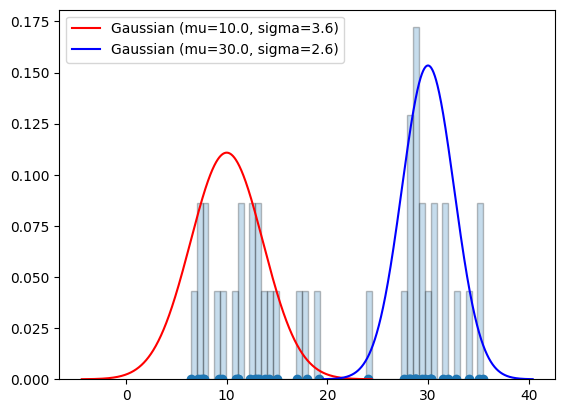

In [75]:
n = 20
mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

# 1)
# Generates data that follows two 2gaussian distributions based on a set of parameters.
def generate_data(n, mu1, sigma1, mu2, sigma2):

  # Generate distributions
  normal_dist1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))
  normal_dist2 = torch.distributions.Normal(torch.tensor([mu2]), torch.tensor([sigma2]))

  # Take a sample from each dist
  gaussian_sample1 = normal_dist1.sample((n,1)).squeeze()
  gaussian_sample2 = normal_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gaussian_sample1, gaussian_sample2))
  return X

X = generate_data(n, mu1, sigma1, mu2, sigma2)
print('X = ', X)

plot(X, mu1, sigma1, mu2, sigma2)



In [77]:
# 2)
def init_random_parameters(k=2, range=50):
  """
      Generates randombly mu and sigma parameters
      params: k, range
      return: A Kx2 matrix where colum 0 corresponds to mu and column 1 to sigma
  """
  return torch.rand((k, 2))*range

P = init_random_parameters()
print('P = ', P)

P =  tensor([[25.2233, 15.0969],
        [49.9099, 33.2075]])


In [78]:
# 3)
def calculate_log_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
  # Nota: tal vez deberíamos poner en el latex el proceso desde la función de likelihood sin log hasta esta versión
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)

likelihood_test = calculate_log_likelihood_gaussian_observation(X[0], mu1, sigma1)
print('likelihood_test = ', likelihood_test)

class LikelihoodGuassianUnitTest(unittest.TestCase):

    def test_likelihood_lower_real(self):
      test_data = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([8.0]))
      test_gaussian_sample = torch.tensor(test_data.sample((30,1)).squeeze())

      real_lgo = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 4.0, 8.0)
      false_lgo = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 40.0, 7.0)
      self.assertTrue(abs(real_lgo) < abs(false_lgo))

    def test_likelihood_value(self):
      test_gaussian_sample = torch.tensor([0.34, 0.45, 0.78])
      likelihood = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 4.0, 8.0)
      self.assertAlmostEquals(float(likelihood), -3.2824, 3)

unittest.main(argv=[''], verbosity=2, exit=False)

test_likelihood_lower_real (__main__.LikelihoodGuassianUnitTest) ... <ipython-input-78-e0f985a1e2ca>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_gaussian_sample = torch.tensor(test_data.sample((30,1)).squeeze())
ok
test_likelihood_value (__main__.LikelihoodGuassianUnitTest) ... <ipython-input-78-e0f985a1e2ca>:22: DeprecationWarning: Please use assertAlmostEqual instead.
  self.assertAlmostEquals(float(likelihood), -3.2824, 3)
ok

----------------------------------------------------------------------
Ran 2 tests in 0.010s

OK


likelihood_test =  tensor(-2.2069)


In [79]:
# 4)
def calculate_membership_dataset(X_dataset, Parameters_matrix, k=2):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, k)

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    k_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for k_index, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gaussian_observation(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        k_membership = k_index
    M[x][k_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

M =  tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


<ipython-input-78-e0f985a1e2ca>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


In [80]:
#5)

def recalculate_parameters(X_dataset, Membership_data):
    # TODO: Can we improve this to use torch?
    membership_k1 = Membership_data[:,0]
    membership_k2 = Membership_data[:,1]
    k1_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k1[index] == 1])
    k2_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k2[index] == 1])
    mu_1 = torch.mean(k1_tentative_values)
    mu_2 = torch.mean(k2_tentative_values)
    sigma_1 = torch.std(k1_tentative_values)
    sigma_2 = torch.std(k2_tentative_values)
    return torch.tensor([[mu_1, sigma_1],[mu_2, sigma_2]])

print('Real parameters k1=[{},{}], k2=[{},{}] '.format(mu1, sigma1, mu2, sigma2))
print('Old P parameters: ', P)
P = recalculate_parameters(X, M)
print('New P parameters: ', P)

Real parameters k1=[10.0,3.6], k2=[30.0,2.6] 
Old P parameters:  tensor([[25.2233, 15.0969],
        [49.9099, 33.2075]])
New P parameters:  tensor([[20.9657,  9.7908],
        [    nan,     nan]])


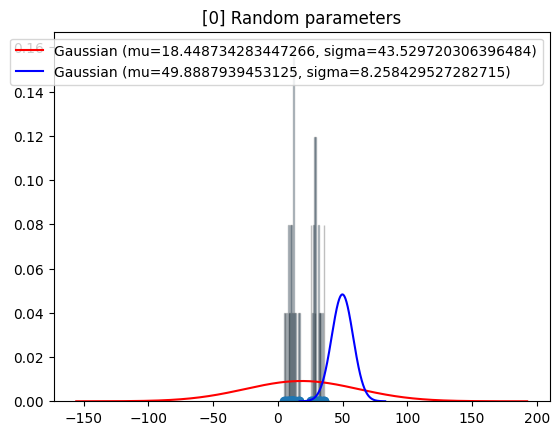

<ipython-input-78-e0f985a1e2ca>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


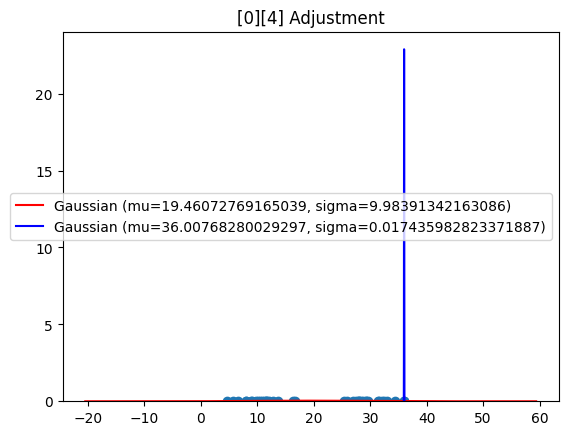

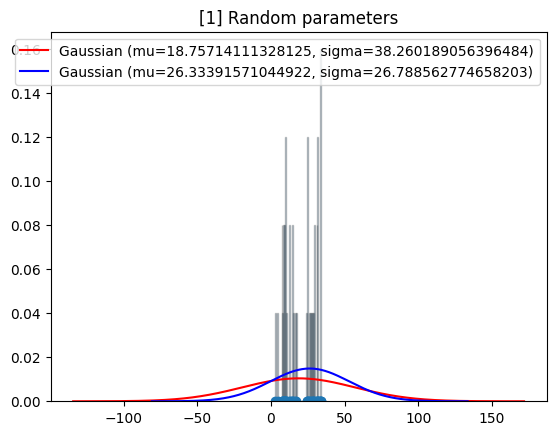

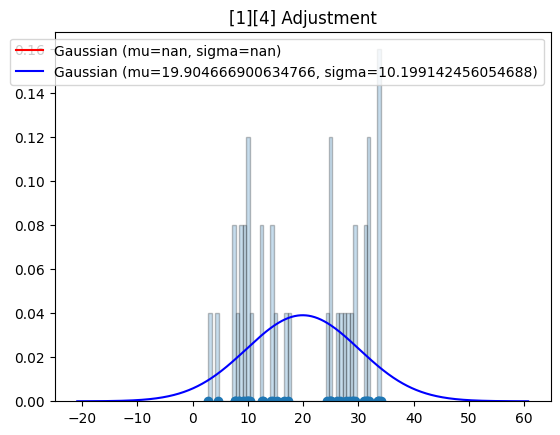

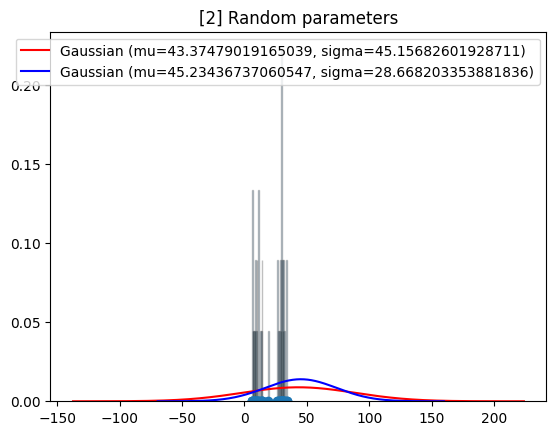

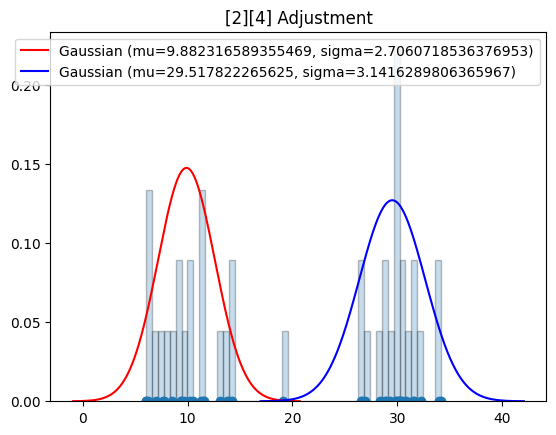

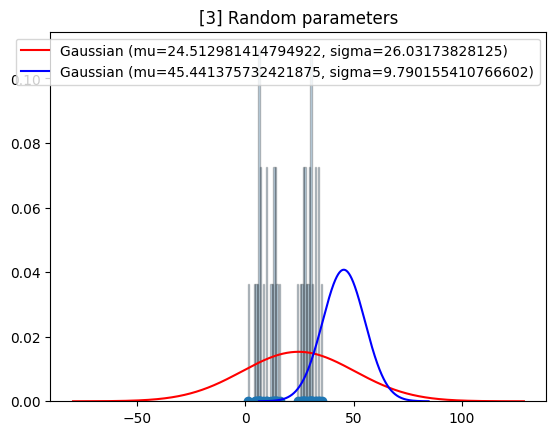

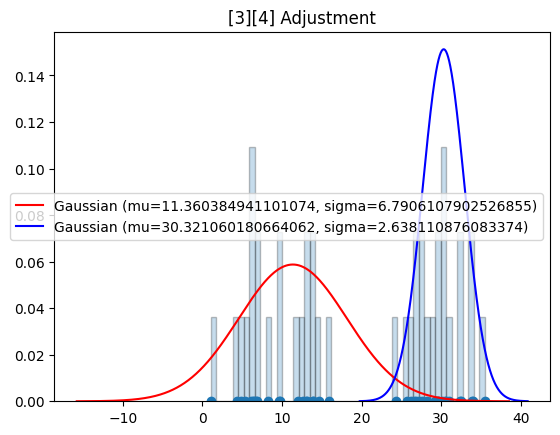

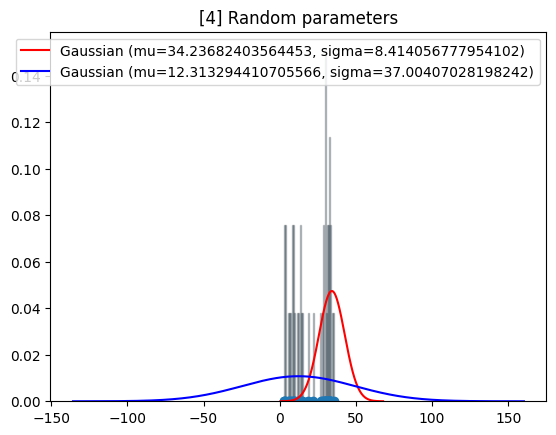

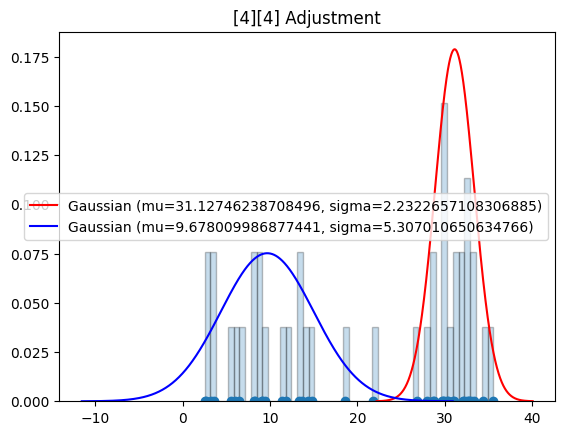

In [81]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = init_random_parameters()
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))

In [82]:
# 7)
def random_parameters_heuristic(X):
    mu = torch.mean(X, dim=0)
    sigma = torch.std(X, dim=0)
    mu_below = mu - sigma
    mu_above = mu + sigma
    mu1 = (mu - mu_below) * torch.rand(1) + mu_below
    sigma1 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    mu2 = (mu_above - mu) * torch.rand(1) + mu
    sigma2 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    return torch.tensor([[mu1, sigma1], [mu2, sigma2]])



PI = random_parameters_heuristic(X)
print(PI)

tensor([[ 9.4849,  4.9818],
        [24.2166,  5.6398]])


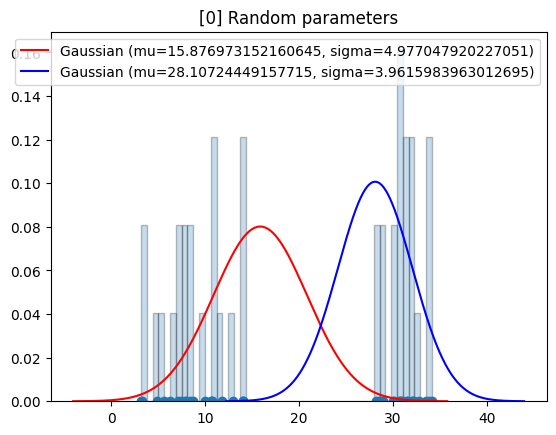

<ipython-input-78-e0f985a1e2ca>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


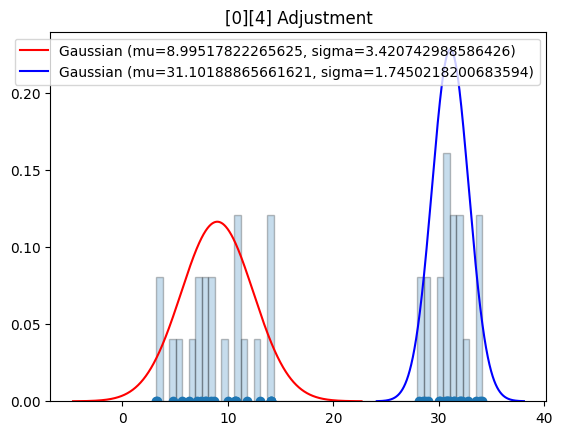

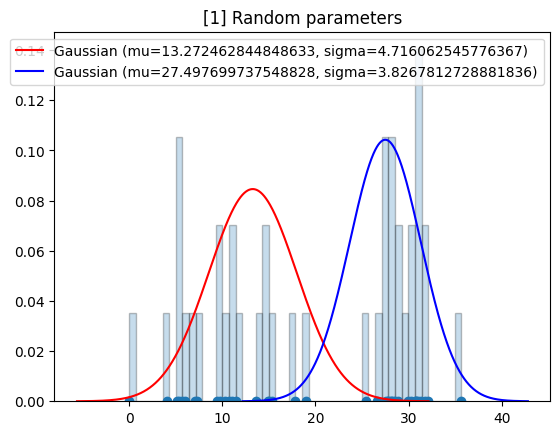

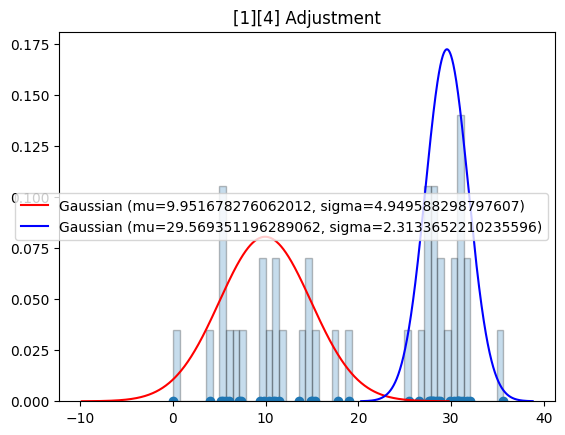

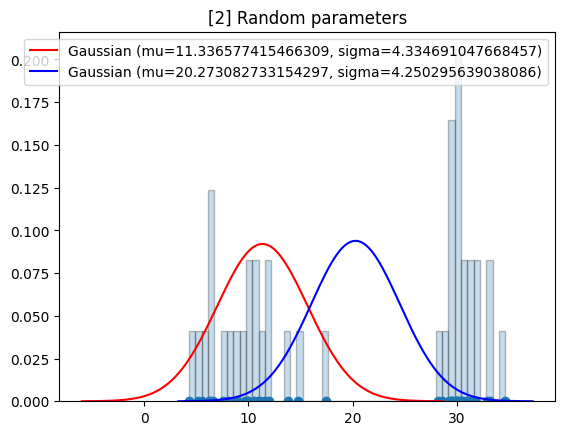

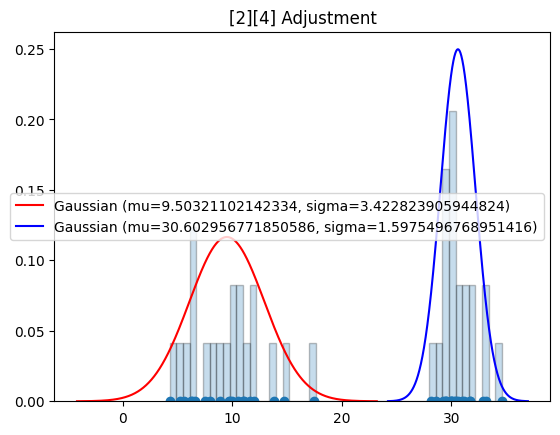

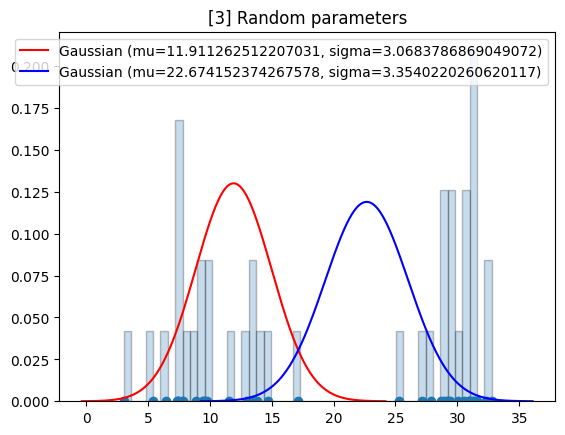

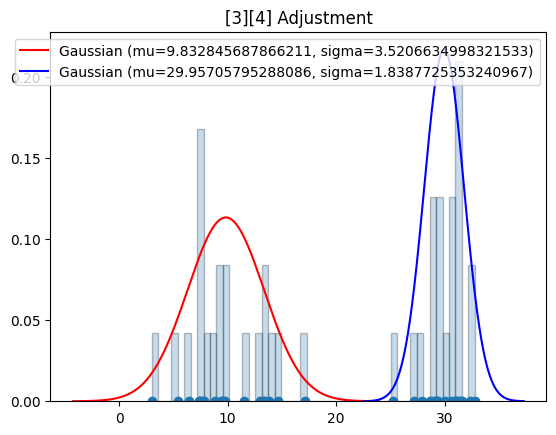

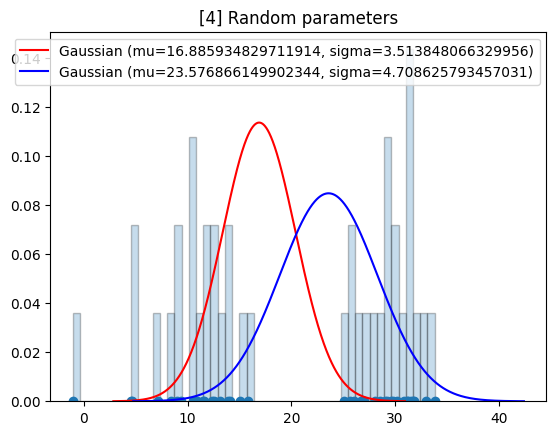

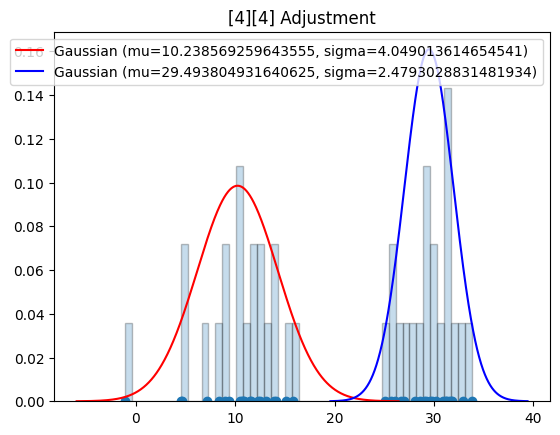

In [83]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = random_parameters_heuristic(X)
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))

#Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gamma)

In [99]:
# Util funcitons

def gamma_distribution_density_data(alpha, beta):
    """
        Given an alpha and a beta, this function returns a tuple representing the X and Y of the PDF

        params: alpha, beta <numbers>
        return: X, Y of the gamma distribution()
    """
    data = torch.linspace(alpha - 4*beta, alpha + 4*beta, 1000)

    # Non Log
    gamma_distribution = (1/((beta**alpha)*gamma(alpha)) * (data**(alpha-1)) * torch.exp(-1 * data/beta))

    # Log
    #gamma_distribution = -1*(alpha*torch.log(torch.tensor(beta))) -1*torch.log(torch.tensor(gamma(alpha))) * ((alpha - 1) * torch.log(data) - (data/beta) )

    return data, gamma_distribution

def plot_gamma(X, alpha1, beta1, alpha2, beta2, title=''):
    # a) Scatter Plot with histograms
    # Histograms
    plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
    # Scatter
    plt.scatter(X,torch.zeros(len(X)))
    # Density
    x1, gamma_density_1 = gamma_distribution_density_data(alpha1, beta1)
    #print('DEBUG: gamma_density_1', gamma_density_1)
    x2, gamma_density_2 = gamma_distribution_density_data(alpha2, beta2)
    plt.plot(x1, gamma_density_1, label=f'Gamma (alpha={alpha1}, beta={beta1})', color='red')
    plt.plot(x2, gamma_density_2, label=f'Gamma (alpha={alpha2}, beta={beta2})', color='blue')
    plt.ylim(0, 2)
    plt.xlim(0,torch.max(X))
    #plt.plot.ylim = (0, 0.3)
    if len(title):
        plt.title(title)
    plt.legend()
    plt.show()

X =  tensor([1.0177, 0.4213, 1.3901, 1.5410, 0.2919, 1.8413, 3.6848, 1.2573, 0.3920,
        0.4888, 0.3844, 0.8818, 0.2588, 0.8771, 0.8959, 0.2295, 0.3299, 2.6304,
        0.8448, 1.6228, 3.1830, 2.3061, 1.1842, 1.9749, 1.4792, 0.2701, 1.0107,
        0.1568, 1.0980, 1.8399, 1.7264, 0.6813, 0.4255, 0.9192, 1.4102, 0.0736,
        5.0227, 1.2531, 0.6768, 1.7532])


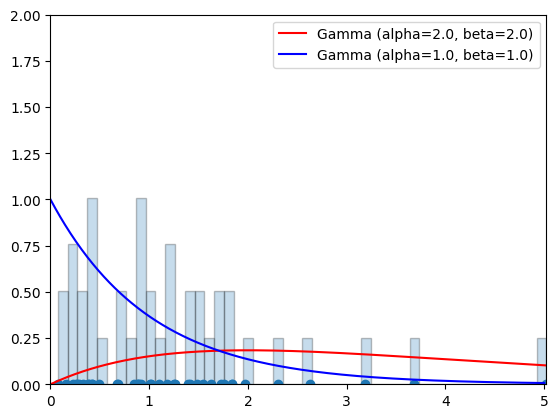

In [101]:
# 2)
alpha1 = 2.0
beta1 = 2.0
alpha2 = 1.0
beta2 = 1.0
# Generates data that follows two gamma distributions based on a set of parameters.
# parameters:
#    * alpha: concentration
#    * beta:  rates
def generate_gamma_data(n, alpha1, beta1, alpha2, beta2):

  # Generate distributions
  gamma_dist1 = torch.distributions.Gamma(torch.tensor([alpha1]), torch.tensor([beta1]))
  gamma_dist2 = torch.distributions.Gamma(torch.tensor([alpha2]), torch.tensor([beta2]))

  # Take a sample from each dist
  gamma_sample1 = gamma_dist1.sample((n,1)).squeeze()
  gamma_sample2 = gamma_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gamma_sample1, gamma_sample2))
  return X

X = generate_gamma_data(n, alpha1, beta1, alpha2, beta2)
print('X = ', X)

plot_gamma(X, alpha1, beta1, alpha2, beta2)


In [102]:
def calculate_likelihood_gamma_observation(x_n, alpha_k, beta_k):
    """
        Given an alpha, a beta, and an x observation this function returns the
        likelyhood that said x belongs to the gamma distribution that results
        from that alpha and beta.

        params: alpha, beta, x <numbers>
        return: likelyhood
    """
    # Non logarithmic gamma distribution.
    if x_n > 0:
      a = 1/((beta_k**alpha_k)*gamma(alpha_k))
      b = x_n**(alpha_k-1)
      c = torch.exp(-1 * x_n/beta_k)
      likelyhood = a * b * c
    else:
      likelyhood = 0

    return likelyhood

def calculate_log_likelihood_gamma_observation(x_n, alpha_k, beta_k):
    """
        Given an alpha, a beta, and an x observation this function returns the
        logarithmic likelyhood that said x belongs to the gamma distribution
        that results from that alpha and beta.

        params: alpha, beta, x <numbers>
        return: likelyhood
    """
    # logarithmic gamma distribution.
    #if x_n > 0:
    a = -1*(alpha_k*torch.log(beta_k))
    b = -1*torch.log(torch.tensor(gamma(alpha_k)))
    c = torch.sum( (alpha_k - 1) * torch.log(x_n) - (x_n/beta_k) )
    likelihood = a + b + c
    #else:
      #likelihood = 0

    return likelihood

In [103]:
# 2)
def init_random_parameters(k=2, range=5):
  """
      Generates randombly mu and sigma parameters
      params: k, range
      return: A Kx2 matrix where colum 0 corresponds to mu and column 1 to sigma
  """
  return torch.rand((k, 2))*range

P = init_random_parameters()
print('P = ', P)

def calculate_membership_dataset_gamma(X_dataset, Parameters_matrix, k=2):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, k)

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    k_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for k_index, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gamma_observation(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        k_membership = k_index
    M[x][k_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

P =  tensor([[0.9521, 3.2687],
        [2.5991, 4.9399]])
M =  tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


<ipython-input-78-e0f985a1e2ca>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


In [108]:
def recalculate_parameters(X_dataset, Membership_data):
    # TODO: Can we improve this to use torch?
    membership_k1 = Membership_data[:,0]
    membership_k2 = Membership_data[:,1]
    k1_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k1[index] == 1])
    k2_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k2[index] == 1])
    alpha_1 = torch.mean(k1_tentative_values)
    alpha_2 = torch.mean(k2_tentative_values)
    beta_1 = torch.std(k1_tentative_values)
    beta_2 = torch.std(k2_tentative_values)
    return torch.tensor([[alpha_1, beta_1],[alpha_2, beta_2]])

print('Real parameters k1=[{},{}], k2=[{},{}] '.format(alpha1, beta1, alpha2, beta2))
print('Old P parameters: ', P)
P = recalculate_parameters(X, M)
print('New P parameters: ', P)

Real parameters k1=[2.0,2.0], k2=[1.0,1.0] 
Old P parameters:  tensor([[-0.5861,  0.5493],
        [ 1.9772,  1.2727]])
New P parameters:  tensor([[-0.5861,  0.5493],
        [ 1.9772,  1.2727]])


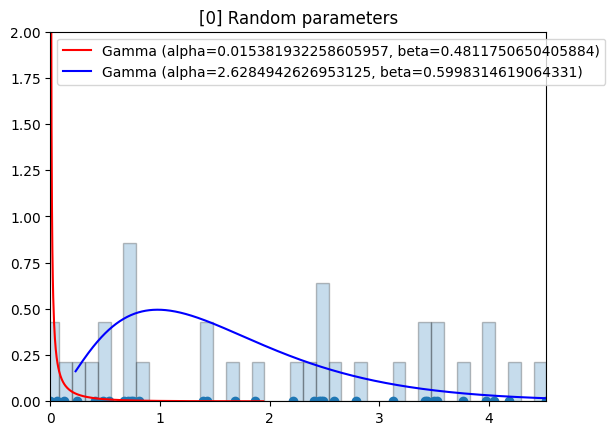

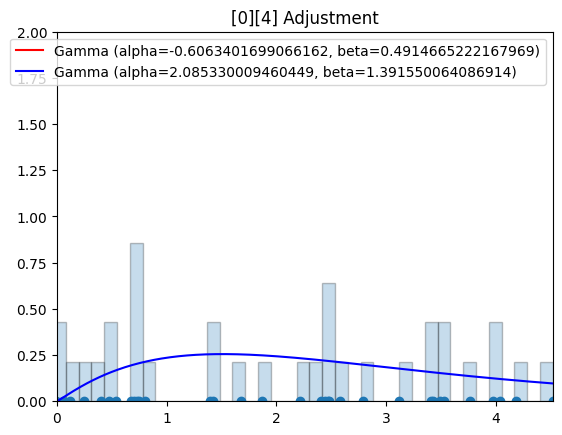

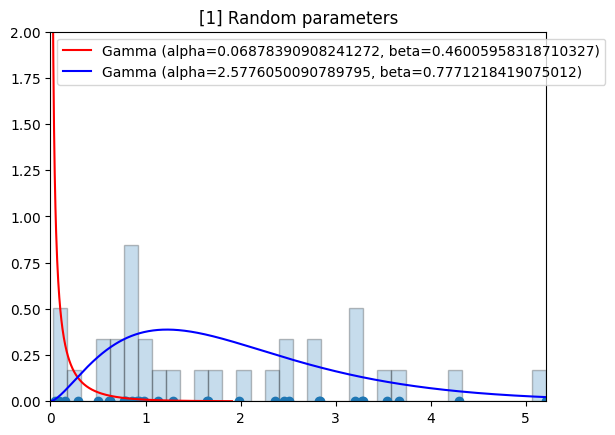

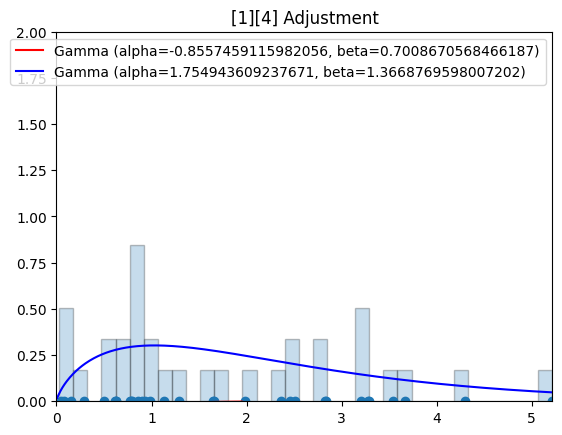

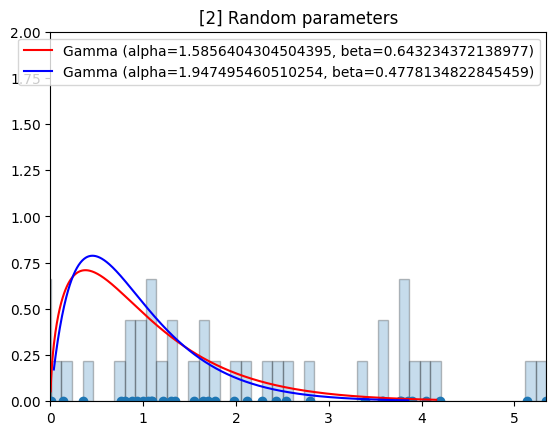

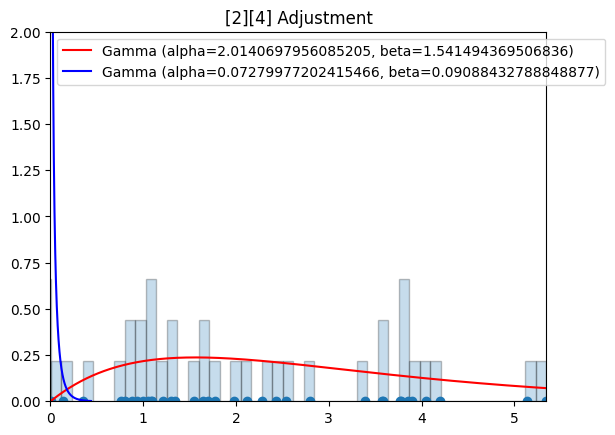

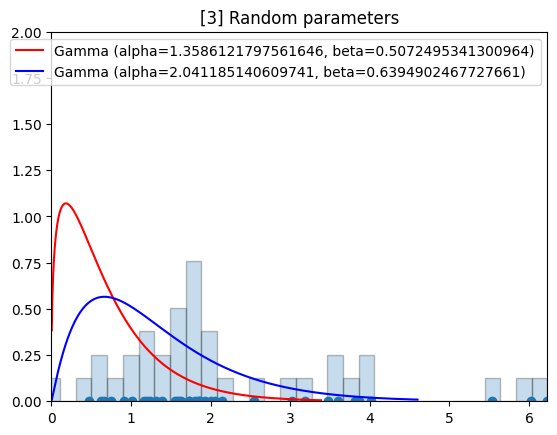

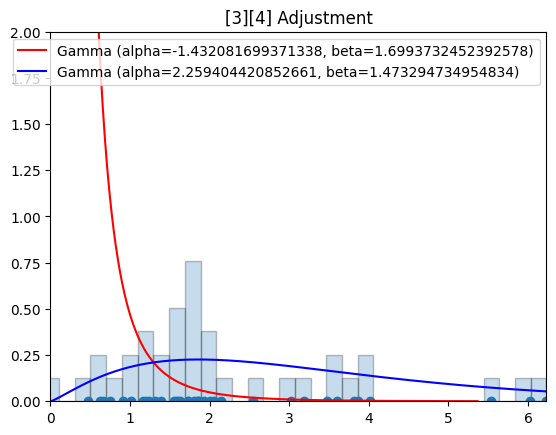

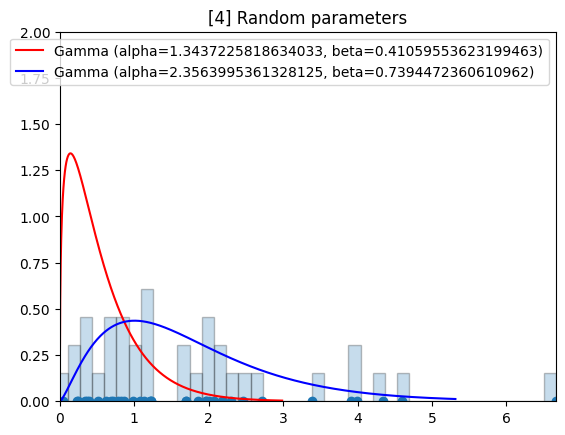

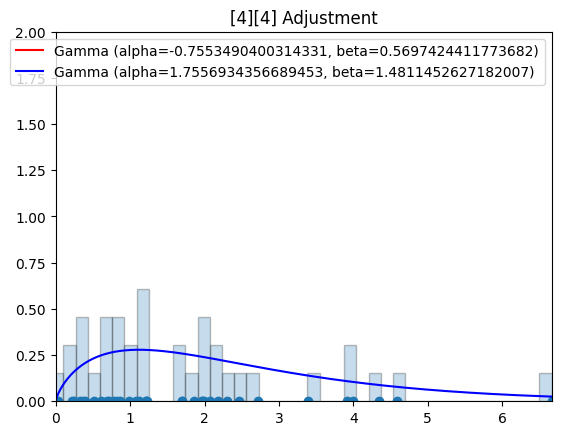

In [109]:
for i in range(i_max):
    X = generate_data(n, alpha1, beta1, alpha2, beta2)
    P = random_parameters_heuristic(X)
    plot_gamma(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset_gamma(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot_gamma(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))